# NYC Taxi Requests Prediction

To demonstrate the demand forecast in each grid at 5min, 15min and 30min slot, we use the yellow New York City Taxi and Limousine Commission (TLC) Trip Record Data between Jan 2018 and June 2018 in Manhattan from AWS public datasets as source data (https://registry.opendata.aws/nyc-tlc-trip-records-pds/). We split the dataset into train part (2018.01.01-2018.05.31) and validate part (2018.06.01-2018.06.30). We demonstrate 4 methods to forecast demand: XGBoost, LightGBM, linear regression implemented using sklearn and linear regression implemented using TensorFlow, and evaluate the models using mean absolute error (MAE).

We mainly use linear regression algorithm as the baseline algorithm, and use XGBoost as the main algorithm. XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way.

To run this notebook, you have to download trip data from Amazon S3 bucket to nyc-tlc directory in your computer:

- https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-01.csv
- https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-02.csv
- https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-03.csv
- https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-04.csv
- https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-05.csv
- https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-06.csv
- https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv
- https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip (unzip)

After download, your local directory structure should be:

```
nyc-tlc
├── misc
│   ├── taxi\ _zone_lookup.csv
│   ├── taxi_zones
│   │   ├── taxi_zones.dbf
│   │   ├── taxi_zones.prj
│   │   ├── taxi_zones.sbn
│   │   ├── taxi_zones.sbx
│   │   ├── taxi_zones.shp
│   │   ├── taxi_zones.shp.xml
│   │   └── taxi_zones.shx
│   └── taxi_zones.zip
└── trip\ data
    ├── yellow_tripdata_2018-01.csv
    ├── yellow_tripdata_2018-02.csv
    ├── yellow_tripdata_2018-03.csv
    ├── yellow_tripdata_2018-04.csv
    ├── yellow_tripdata_2018-05.csv
    └── yellow_tripdata_2018-06.csv

3 directories, 15 files
```

In [ ]:
# TODO download data and unzip archive file commands [Question 1]
!aws s3 cp s3://nyc-tlc/trip\ data/yellow_tripdata_2018-01.csv nyc-tlc/trip\ data/yellow_tripdata_2018-01.csv
!aws s3 cp s3://nyc-tlc/trip\ data/yellow_tripdata_2018-02.csv nyc-tlc/trip\ data/yellow_tripdata_2018-02.csv
!aws s3 cp s3://nyc-tlc/trip\ data/yellow_tripdata_2018-03.csv nyc-tlc/trip\ data/yellow_tripdata_2018-03.csv
!aws s3 cp s3://nyc-tlc/trip\ data/yellow_tripdata_2018-04.csv nyc-tlc/trip\ data/yellow_tripdata_2018-04.csv
!aws s3 cp s3://nyc-tlc/trip\ data/yellow_tripdata_2018-05.csv nyc-tlc/trip\ data/yellow_tripdata_2018-05.csv
!aws s3 cp s3://nyc-tlc/trip\ data/yellow_tripdata_2018-06.csv nyc-tlc/trip\ data/yellow_tripdata_2018-06.csv
!aws s3 cp s3://nyc-tlc/misc/taxi\ _zone_lookup.csv nyc-tlc/misc/taxi\ _zone_lookup.csv
!aws s3 cp s3://nyc-tlc/misc/taxi_zones.zip nyc-tlc/misc/taxi_zones.zip
!cd nyc-tlc/misc/ && unzip taxi_zones.zip -d taxi_zones

download: s3://nyc-tlc/trip data/yellow_tripdata_2018-01.csv to nyc-tlc/trip data/yellow_tripdata_2018-01.csv
download: s3://nyc-tlc/trip data/yellow_tripdata_2018-02.csv to nyc-tlc/trip data/yellow_tripdata_2018-02.csv
download: s3://nyc-tlc/trip data/yellow_tripdata_2018-03.csv to nyc-tlc/trip data/yellow_tripdata_2018-03.csv
download: s3://nyc-tlc/trip data/yellow_tripdata_2018-04.csv to nyc-tlc/trip data/yellow_tripdata_2018-04.csv
download: s3://nyc-tlc/trip data/yellow_tripdata_2018-05.csv to nyc-tlc/trip data/yellow_tripdata_2018-05.csv
download: s3://nyc-tlc/trip data/yellow_tripdata_2018-06.csv to nyc-tlc/trip data/yellow_tripdata_2018-06.csv
download: s3://nyc-tlc/misc/taxi _zone_lookup.csv to nyc-tlc/misc/taxi _zone_lookup.csv
download: s3://nyc-tlc/misc/taxi_zones.zip to nyc-tlc/misc/taxi_zones.zip
Archive:  taxi_zones.zip
replace taxi_zones/taxi_zones.prj? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
# Validate [Question 1]
!tree nyc-tlc


nyc-tlc
├── misc
│   ├── taxi\ _zone_lookup.csv
│   ├── taxi_zones
│   │   ├── taxi_zones.dbf
│   │   ├── taxi_zones.prj
│   │   ├── taxi_zones.sbn
│   │   ├── taxi_zones.sbx
│   │   ├── taxi_zones.shp
│   │   ├── taxi_zones.shp.xml
│   │   └── taxi_zones.shx
│   └── taxi_zones.zip
└── trip\ data
    ├── yellow_tripdata_2018-01.csv
    ├── yellow_tripdata_2018-02.csv
    ├── yellow_tripdata_2018-03.csv
    ├── yellow_tripdata_2018-04.csv
    ├── yellow_tripdata_2018-05.csv
    └── yellow_tripdata_2018-06.csv

3 directories, 15 files


You should get:

```
nyc-tlc
├── misc
│   ├── taxi\ _zone_lookup.csv
│   ├── taxi_zones
│   │   ├── taxi_zones.dbf
│   │   ├── taxi_zones.prj
│   │   ├── taxi_zones.sbn
│   │   ├── taxi_zones.sbx
│   │   ├── taxi_zones.shp
│   │   ├── taxi_zones.shp.xml
│   │   └── taxi_zones.shx
│   └── taxi_zones.zip
└── trip\ data
    ├── yellow_tripdata_2018-01.csv
    ├── yellow_tripdata_2018-02.csv
    ├── yellow_tripdata_2018-03.csv
    ├── yellow_tripdata_2018-04.csv
    ├── yellow_tripdata_2018-05.csv
    └── yellow_tripdata_2018-06.csv

3 directories, 15 files
```

## Basic Prepare

We import all useful packages, and set the `first_datetime` to 2018-01-01 00:00:00, and `last_datetime` to 2018-07-01 00:00:00. We split the dataset into two parts: train and validate, by setting the `train_valid_split_datetime` to 2018-06-01 00:00:00.

In [1]:
# imports
import time
import pickle
import datetime
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae


ImportError: libkea.so.1.4.7: cannot open shared object file: No such file or directory

In [2]:
# global setting
plt.rcParams['figure.figsize'] = [12, 8]
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

NameError: name 'plt' is not defined

In [ ]:
def get_5min_id(x):
    return int((x-first_datetime).total_seconds()//(5*60))

def get_15min_id(x):
    return int((x-first_datetime).total_seconds()//(15*60))

def get_30min_id(x):
    return int((x-first_datetime).total_seconds()//(30*60))

In [6]:
# time setting
first_datetime = datetime.datetime.strptime('2018-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
last_datetime = datetime.datetime.strptime('2018-07-01 00:00:00', '%Y-%m-%d %H:%M:%S')  # '2018-07-01 00:00:00'
train_valid_split_datetime = datetime.datetime.strptime('2018-06-01 00:00:00', '%Y-%m-%d %H:%M:%S')  # '2018-06-01 00:00:00'
print('first_datetime:', first_datetime)
print('last_datetime:', last_datetime)
print('train_valid_split_datetime:', train_valid_split_datetime)

first_5min_id = get_5min_id(first_datetime)
first_15min_id = get_15min_id(first_datetime)
first_30min_id = get_30min_id(first_datetime)
print('first_5min_id:', first_5min_id)
print('first_15min_id:', first_15min_id)
print('first_30min_id:', first_30min_id)

last_5min_id = get_5min_id(last_datetime)
last_15min_id = get_15min_id(last_datetime)
last_30min_id = get_30min_id(last_datetime)
print('last_5min_id:', last_5min_id)
print('last_15min_id:', last_15min_id)
print('last_30min_id:', last_30min_id)

train_valid_split_5min_id = get_5min_id(train_valid_split_datetime)
train_valid_split_15min_id = get_15min_id(train_valid_split_datetime)
train_valid_split_30min_id = get_30min_id(train_valid_split_datetime)
print('train_valid_split_5min_id:', train_valid_split_5min_id)
print('train_valid_split_15min_id:', train_valid_split_15min_id)
print('train_valid_split_30min_id:', train_valid_split_30min_id)

first_datetime: 2018-01-01 00:00:00
last_datetime: 2018-07-01 00:00:00
train_valid_split_datetime: 2018-06-01 00:00:00
first_5min_id: 0
first_15min_id: 0
first_30min_id: 0
last_5min_id: 52128
last_15min_id: 17376
last_30min_id: 8688
train_valid_split_5min_id: 43488
train_valid_split_15min_id: 14496
train_valid_split_30min_id: 7248


## Taxi Zones

Since newest NYC Taxi dataset only provides `PULocationID` and `DOLocationID`, instead of `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, and `dropoff_latitude`, we can only predict requests in each `PULocationID` (zone). We load [taxi _zone_lookup.csv] and [taxi_zones.shp], and use `geopandas` to visualize the zones in Manhattan (69 in total).

In [7]:
# Manhattan taxi zone lookup
taxi_zone_lookup = pd.read_csv('nyc-tlc/misc/taxi _zone_lookup.csv')
print('taxi_zone_lookup:', taxi_zone_lookup.shape)
manhattan_location_ids = taxi_zone_lookup[taxi_zone_lookup['Borough']=='Manhattan']['LocationID'].values
manhattan_location_num = len(manhattan_location_ids)
print('manhattan_location_ids:', manhattan_location_ids.shape, manhattan_location_ids)
print('manhattan_location_num:', manhattan_location_num)

taxi_zone_lookup: (265, 4)
manhattan_location_ids: (69,) [  4  12  13  24  41  42  43  45  48  50  68  74  75  79  87  88  90 100
 103 104 105 107 113 114 116 120 125 127 128 137 140 141 142 143 144 148
 151 152 153 158 161 162 163 164 166 170 186 194 202 209 211 224 229 230
 231 232 233 234 236 237 238 239 243 244 246 249 261 262 263]
manhattan_location_num: 69


In [8]:
taxi_zone_lookup.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [9]:
# Manhattan taxi zones shape
taxi_zones_shape = gp.GeoDataFrame.from_file('nyc-tlc/misc/taxi_zones/taxi_zones.shp')
taxi_zones_shape = taxi_zones_shape[taxi_zones_shape['borough'] == 'Manhattan']
taxi_zones_shape.head()


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
3,4,0.044,0.000,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,..."
11,12,0.037,0.000,Battery Park,12,Manhattan,"POLYGON ((979908.771901235 196066.5651661754, ..."
12,13,0.050,0.000,Battery Park City,13,Manhattan,"POLYGON ((980801.3095727563 201248.8694928288,..."
23,24,0.047,0.000,Bloomingdale,24,Manhattan,"POLYGON ((995453.1139255464 230274.2667761594,..."
40,41,0.053,0.000,Central Harlem,41,Manhattan,"POLYGON ((998716.9128961712 234240.3971749842,..."


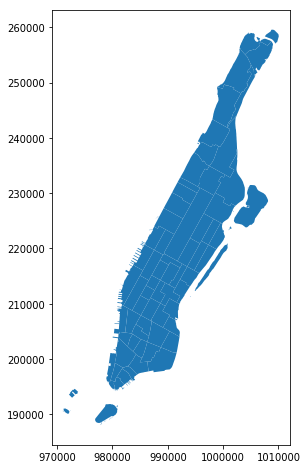

In [10]:
# visualize Manhattan taxi zones shape
taxi_zones_shape.plot()


## Data Prepare

We load all data from [nyc-tlc/trip data/] between Jan and June 2018, and filter abnormal data. We use `matplotlib` and `geopandas` to visualize some columns and help us to understand the trip data.

In [11]:
# filter abnormal data: tpep_pickup_datetime, tpep_dropoff_datetime, trip_distance, trip duration, trip_speed, total_amount, etc.
def filter_abnormal_data(sample):
    start = time.time()
    sample_manhattan = sample[sample['PULocationID'].isin(manhattan_location_ids)].copy()
    print('filter PULocationID:', sample_manhattan.shape, time.time()-start)
    sample_manhattan['tpep_pickup_datetime'] = pd.to_datetime(sample_manhattan['tpep_pickup_datetime'])
    print('tpep_pickup_datetime:', time.time()-start)
    sample_manhattan['tpep_dropoff_datetime'] = pd.to_datetime(sample_manhattan['tpep_dropoff_datetime'])
    print('tpep_dropoff_datetime:', time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['tpep_pickup_datetime'] >= first_datetime]
    print('filter tpep_pickup_datetime first_datetime:', sample_manhattan.shape, time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['tpep_pickup_datetime'] < last_datetime]
    print('filter tpep_pickup_datetime last_datetime:', sample_manhattan.shape, time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['trip_distance'] > 0]
    print('filter trip_distance:', sample_manhattan.shape, time.time()-start)
    sample_manhattan['trip_duration'] = (sample_manhattan['tpep_dropoff_datetime']-sample_manhattan['tpep_pickup_datetime']).dt.total_seconds()
    print('trip_duration:', time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['trip_duration'] > 0]
    print('filter trip_duration:', sample_manhattan.shape, time.time()-start)
    sample_manhattan['trip_speed'] = sample_manhattan['trip_distance']/sample_manhattan['trip_duration']*3600
    print('trip_speed:', time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['trip_speed'] > 0]
    sample_manhattan = sample_manhattan[sample_manhattan['trip_speed'] <= 200]
    print('filter trip_speed:', sample_manhattan.shape, time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['total_amount'] > 0]
    print('filter total_amount:', sample_manhattan.shape, time.time()-start)
    return sample_manhattan

In [12]:
# load Manhattan data: from 2018-01 to 2018-06, call filter_abnormal_data to filter data [Question 2]
for m in range(1, 7):  # (1, 7)
    start = time.time()
    
    # TODO call pandas function to read csv from csv file, return variable should be sample_1
    sample_1 = pd.read_csv('nyc-tlc/trip data/yellow_tripdata_2018-0' + str(m) + '.csv')
    
    print('read_csv 2018-0'+str(m)+':', time.time()-start)
    sample_1 = filter_abnormal_data(sample_1)
    print('filter_abnormal_data:', time.time()-start)
    if m == 1:
        sample_manhattan = sample_1
    else:
        
        # TODO concat sample_manhattan and sample_1
        sample_manhattan = pd.concat([sample_manhattan, sample_1], axis=0)
        
    print('concat:', time.time()-start)

read_csv 2018-01: 13.502095222473145
filter PULocationID: (7965703, 17) 2.1527721881866455
tpep_pickup_datetime: 3.6772499084472656
tpep_dropoff_datetime: 5.114041328430176
filter tpep_pickup_datetime first_datetime: (7965469, 17) 6.073052167892456
filter tpep_pickup_datetime last_datetime: (7965463, 17) 6.874722242355347
filter trip_distance: (7934895, 17) 7.673456192016602
trip_duration: 8.680543184280396
filter trip_duration: (7934778, 18) 10.257695436477661
trip_speed: 10.471818447113037
filter trip_speed: (7931601, 19) 13.01816987991333
filter total_amount: (7928563, 19) 13.876592874526978
filter_abnormal_data: 27.560188055038452
concat: 27.560275316238403
read_csv 2018-02: 12.97013258934021
filter PULocationID: (7767881, 17) 2.072634696960449
tpep_pickup_datetime: 3.5646440982818604
tpep_dropoff_datetime: 4.977169990539551
filter tpep_pickup_datetime first_datetime: (7767797, 17) 5.909488201141357
filter tpep_pickup_datetime last_datetime: (7767791, 17) 6.680656433105469
filter t

In [13]:
# Validate [Question 2]
print('sample_manhattan:', sample_manhattan.shape)

sample_manhattan: (48730027, 19)


You should get `sample_manhattan: (48730027, 19)`

In [14]:
# filter too large total_amount, trip_distance, trip_duration
start = time.time()

m = np.mean(sample_manhattan['total_amount'])
s = np.std(sample_manhattan['total_amount'])
print('total_amount m:', m, 's:', s)
sample_manhattan = sample_manhattan[sample_manhattan['total_amount'] <= m + 10*s]
#sample_manhattan = sample_manhattan[sample_manhattan['total_amount'] >= m - 10*s]
print('filter total_amount:', sample_manhattan.shape, time.time()-start)

m = np.mean(sample_manhattan['trip_distance'])
s = np.std(sample_manhattan['trip_distance'])
print('trip_distance m:', m, 's:', s)
sample_manhattan = sample_manhattan[sample_manhattan['trip_distance'] <= m + 20*s]
#sample_manhattan = sample_manhattan[sample_manhattan['trip_distance'] >= m - 20*s]
print('filter trip_distance:', sample_manhattan.shape, time.time()-start)

m = np.mean(sample_manhattan['trip_duration'])
s = np.std(sample_manhattan['trip_duration'])
print('trip_duration m:', m, 's:', s)
sample_manhattan = sample_manhattan[sample_manhattan['trip_duration'] <= m + 2*s]
#sample_manhattan = sample_manhattan[sample_manhattan['trip_duration'] >= m - 2*s]
print('filter trip_duration:', sample_manhattan.shape, time.time()-start)

print('sample_manhattan.shape:', sample_manhattan.shape)

total_amount m: 14.076093120901941 s: 43.312344794839746
filter total_amount: (48729900, 19) 13.347257852554321
trip_distance m: 2.334439289429907 s: 2.654608138803723
filter trip_distance: (48729537, 19) 18.84695792198181
trip_duration m: 928.0043776939641 s: 3705.3834692800156
filter trip_duration: (48632711, 19) 24.345361471176147
sample_manhattan.shape: (48632711, 19)


In [15]:
# append, change and drop columns
start = time.time()
sample_manhattan['store_and_fwd_flag'] = sample_manhattan['store_and_fwd_flag'].map(lambda x: x == 'N' and 0 or 1)
print('store_and_fwd_flag:', time.time()-start)

sample_manhattan['tpep_pickup_5min_id'] = (sample_manhattan['tpep_pickup_datetime']-first_datetime).dt.total_seconds()//(5*60)
print('tpep_pickup_5min_id:', time.time()-start)
sample_manhattan['tpep_pickup_15min_id'] = (sample_manhattan['tpep_pickup_datetime']-first_datetime).dt.total_seconds()//(15*60)
print('tpep_pickup_15min_id:', time.time()-start)
sample_manhattan['tpep_pickup_30min_id'] = (sample_manhattan['tpep_pickup_datetime']-first_datetime).dt.total_seconds()//(30*60)
print('tpep_pickup_30min_id:', time.time()-start)

sample_manhattan.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1, inplace=True)  # , 'tpep_pickup_date', 'tpep_dropoff_date'
print('sample_manhattan.shape:', sample_manhattan.shape)

store_and_fwd_flag: 11.691474676132202
tpep_pickup_5min_id: 17.93738603591919
tpep_pickup_15min_id: 21.627917051315308
tpep_pickup_30min_id: 25.31878924369812
sample_manhattan.shape: (48632711, 20)


In [16]:
# Show first 5 rows of sample_manhattan [Question 3.1]
sample_manhattan.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,trip_speed,tpep_pickup_5min_id,tpep_pickup_15min_id,tpep_pickup_30min_id
0,1,1,0.500,1,1,41,24,2,4.500,0.500,0.500,0.000,0.000,0.300,5.800,198.000,9.091,4.000,1.000,0.000
1,1,1,2.700,1,1,239,140,2,14.000,0.500,0.500,0.000,0.000,0.300,15.300,1090.000,8.917,8.000,2.000,1.000
2,1,2,0.800,1,1,262,141,1,6.000,0.500,0.500,1.000,0.000,0.300,8.300,355.000,8.113,1.000,0.000,0.000
3,1,1,10.200,1,1,140,257,2,33.500,0.500,0.500,0.000,0.000,0.300,34.800,1949.000,18.840,4.000,1.000,0.000
4,1,2,2.500,1,1,246,239,1,12.500,0.500,0.500,2.750,0.000,0.300,16.550,1068.000,8.427,1.000,0.000,0.000


In [17]:
# Show statistics of sample_manhattan [Question 3.2]
sample_manhattan.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,trip_speed,tpep_pickup_5min_id,tpep_pickup_15min_id,tpep_pickup_30min_id
count,48632711.000,48632711.000,48632711.000,48632711.000,48632711.000,48632711.000,48632711.000,48632711.000,48632711.000,48632711.000,48632711.000,48632711.000,48632711.000,48632711.000,48632711.000,48632711.000,48632711.000,48632711.000,48632711.000,48632711.000
mean,1.568,1.602,2.332,1.016,1.000,164.233,161.415,1.306,11.141,0.325,0.499,1.631,0.158,0.300,14.057,766.998,10.662,26104.130,8701.044,4350.272
std,0.496,1.250,2.642,0.202,0.000,66.538,69.231,0.475,8.240,0.407,0.027,2.006,1.137,0.002,10.229,567.381,5.321,14787.540,4929.180,2464.590
min,1.000,0.000,0.010,1.000,1.000,4.000,1.000,1.000,0.000,-60.000,0.000,0.000,0.000,0.000,0.300,1.000,0.004,0.000,0.000,0.000
25%,1.000,1.000,0.920,1.000,1.000,113.000,113.000,1.000,6.500,0.000,0.500,0.000,0.000,0.300,8.300,381.000,7.256,13235.000,4411.000,2205.000
50%,2.000,1.000,1.500,1.000,1.000,162.000,162.000,1.000,9.000,0.000,0.500,1.360,0.000,0.300,11.300,624.000,9.631,26155.000,8718.000,4359.000
75%,2.000,2.000,2.600,1.000,1.000,234.000,233.000,2.000,13.000,0.500,0.500,2.260,0.000,0.300,15.960,990.000,12.763,38676.000,12892.000,6446.000
max,4.000,192.000,55.410,99.000,1.000,263.000,265.000,4.000,420.000,66.660,60.800,411.500,355.350,0.600,433.800,8337.000,200.000,52127.000,17375.000,8687.000


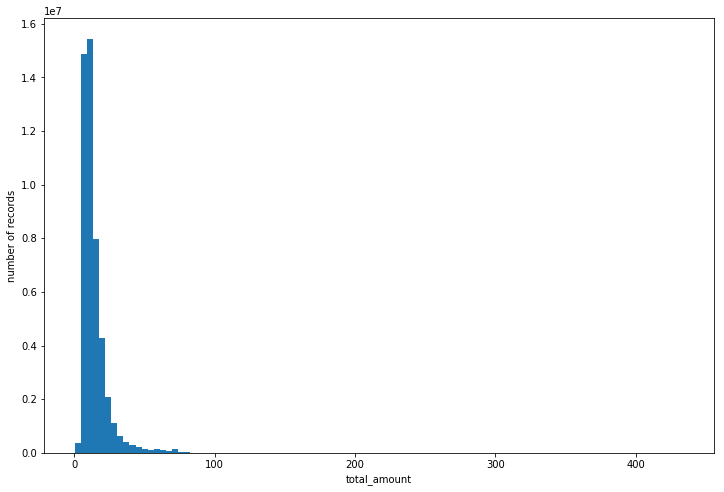

In [18]:
plt.hist(sample_manhattan['total_amount'].values, bins=100)
plt.xlabel('total_amount')
plt.ylabel('number of records')
plt.show()

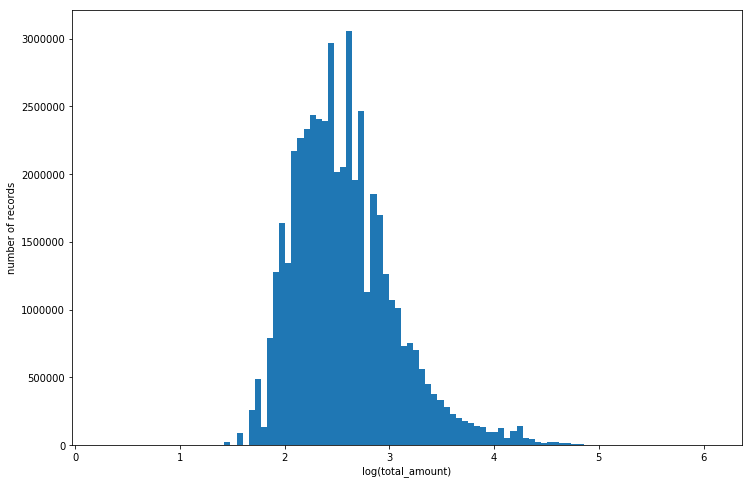

In [19]:
sample_manhattan['log_total_amount'] = np.log(sample_manhattan['total_amount'].values + 1)
plt.hist(sample_manhattan['log_total_amount'].values, bins=100)
plt.xlabel('log(total_amount)')
plt.ylabel('number of records')
plt.show()

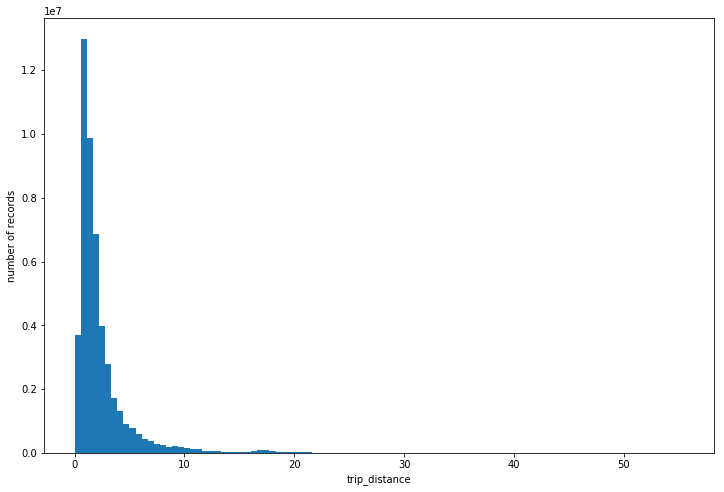

In [20]:
plt.hist(sample_manhattan['trip_distance'].values, bins=100)
plt.xlabel('trip_distance')
plt.ylabel('number of records')
plt.show()

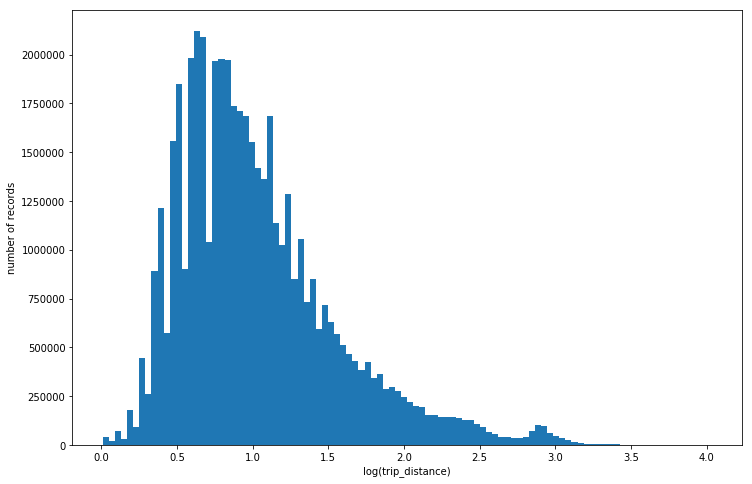

In [21]:
sample_manhattan['log_trip_distance'] = np.log(sample_manhattan['trip_distance'].values + 1)
plt.hist(sample_manhattan['log_trip_distance'].values, bins=100)
plt.xlabel('log(trip_distance)')
plt.ylabel('number of records')
plt.show()

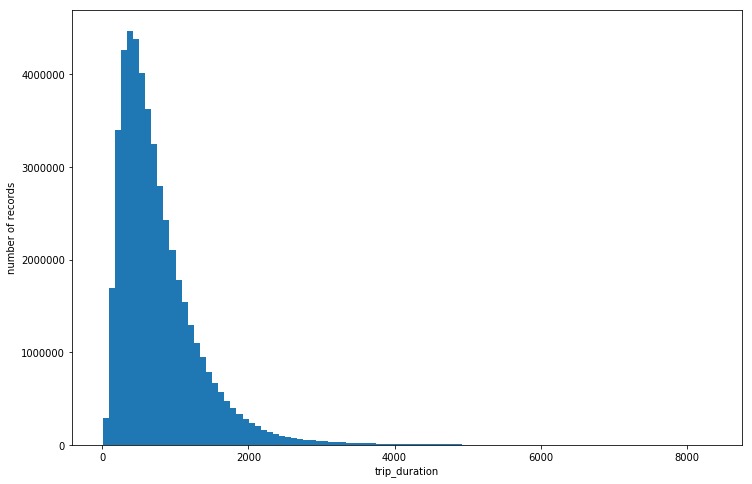

In [22]:
plt.hist(sample_manhattan['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of records')
plt.show()

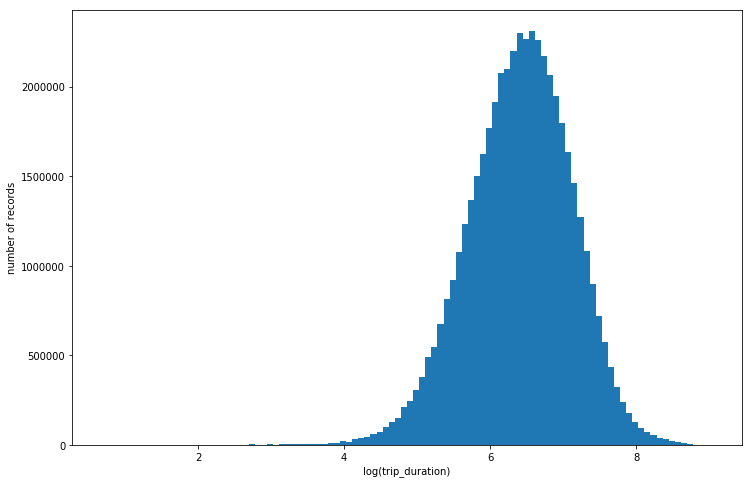

In [23]:
sample_manhattan['log_trip_duration'] = np.log(sample_manhattan['trip_duration'].values + 1)
plt.hist(sample_manhattan['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of records')
plt.show()

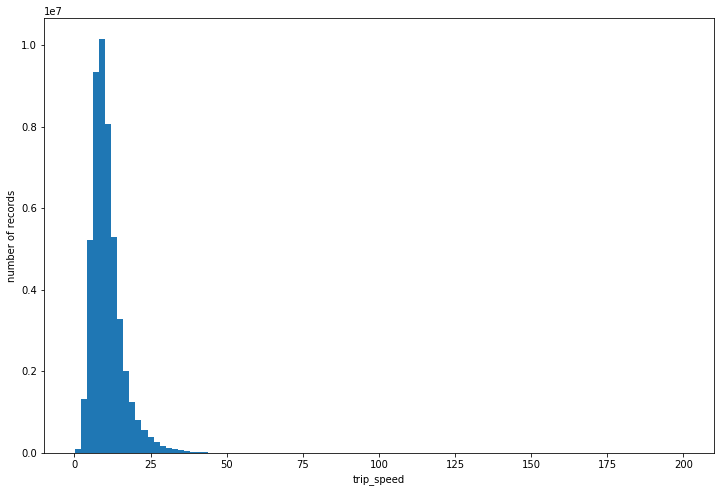

In [24]:
plt.hist(sample_manhattan['trip_speed'].values, bins=100)
plt.xlabel('trip_speed')
plt.ylabel('number of records')
plt.show()

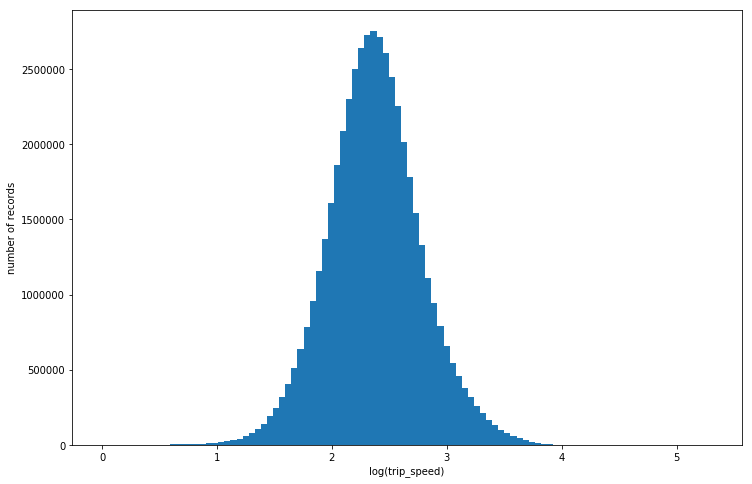

In [25]:
sample_manhattan['log_trip_speed'] = np.log(sample_manhattan['trip_speed'].values + 1)
plt.hist(sample_manhattan['log_trip_speed'].values, bins=100)
plt.xlabel('log(trip_speed)')
plt.ylabel('number of records')
plt.show()

In [26]:
PULocationID_group = sample_manhattan.groupby(['PULocationID']).count()[['VendorID']]
PULocationID_group.head()

,VendorID
PULocationID,
4,116900
12,21911
13,481375
24,162278
41,212347


In [27]:
taxi_zones_shape_requests = taxi_zones_shape.join(PULocationID_group, on=['LocationID'], how='left')
taxi_zones_shape_requests.fillna(0, inplace=True)
print('taxi_zones_shape_requests:', taxi_zones_shape_requests.shape)

taxi_zones_shape_requests: (69, 8)


In [28]:
taxi_zones_shape_requests.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,VendorID
3,4,0.044,0.000,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",116900.000
11,12,0.037,0.000,Battery Park,12,Manhattan,"POLYGON ((979908.771901235 196066.5651661754, ...",21911.000
12,13,0.050,0.000,Battery Park City,13,Manhattan,"POLYGON ((980801.3095727563 201248.8694928288,...",481375.000
23,24,0.047,0.000,Bloomingdale,24,Manhattan,"POLYGON ((995453.1139255464 230274.2667761594,...",162278.000
40,41,0.053,0.000,Central Harlem,41,Manhattan,"POLYGON ((998716.9128961712 234240.3971749842,...",212347.000


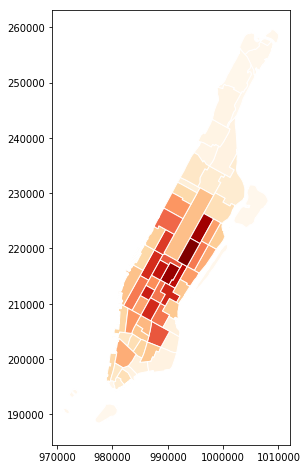

In [29]:
taxi_zones_shape_requests.plot(column='VendorID', cmap='OrRd', edgecolor='white')

## Feature Prepare

We set the `5min_id`, `15min_id` and `30min_id` to represent 5min, 15min and 30min slot. For example, time between 2018-01-01 00:00:00 and 2018-01-01 00:05:00 has a `5min_id` as 0, and time between 2018-01-01 00:05:00 and 2018-01-01 00:10:00 has a `5min_id` as 1, and the similar with `15min_id` and `30min_id`. For each `Xmin_id` (X represents 5, 15 or 30), we predict the requests in all 69 zones. We have some `static features` such as `month`, `day`, `hour`, `weekday`, `is_weekend`, `is_morning_peak`, `is_evening_pick` for all `Xmin_id` and zones. Also we can extend more static features such as weather and zone features. Other `dynamic features` includes requests in `5min ago`, `10min ago`, `15min ago`, `7days ago`, etc. Also we can extend more dynamic features such as total passengers in 5min ago. At last, we generate 34 features for each `Xmin_id` and zone.

In [30]:
def get_all_index_and_static(last_id, id_name):
    start = time.time()
    all_id = np.array([i for i in range(int(last_id)) for _ in range(manhattan_location_num)])
    all_LocationID = np.array([i for _ in range(int(last_id)) for i in manhattan_location_ids])
    print('all_id:', all_id.shape, all_id)
    print('all_LocationID:', all_LocationID.shape, all_LocationID)

    all_index = pd.DataFrame({id_name: all_id, 'LocationID': all_LocationID})
    all_index.set_index([id_name, 'LocationID'], inplace=True)
    print('all_index:', all_index.shape)

    all_static = pd.DataFrame({id_name: all_id, 'LocationID': all_LocationID})
    all_static['tpep_pickup_datetime'] = pd.to_timedelta(all_static[id_name]*5*60, unit='s') + first_datetime
    print('tpep_pickup_datetime:', time.time()-start)
    #all_static['tpep_pickup_year'] = all_static['tpep_pickup_datetime'].dt.year
    #print('tpep_pickup_year:', time.time()-start)
    all_static['tpep_pickup_month'] = all_static['tpep_pickup_datetime'].dt.month
    print('tpep_pickup_month:', time.time()-start)
    all_static['tpep_pickup_day'] = all_static['tpep_pickup_datetime'].dt.day
    print('tpep_pickup_day:', time.time()-start)
    all_static['tpep_pickup_hour'] = all_static['tpep_pickup_datetime'].dt.hour
    print('tpep_pickup_hour:', time.time()-start)
    all_static['tpep_pickup_weekday'] = all_static['tpep_pickup_datetime'].dt.weekday
    print('tpep_pickup_weekday:', time.time()-start)
    all_static['is_weekend'] = all_static['tpep_pickup_weekday'].map(lambda x: x >= 5 and 1 or 0)
    print('is_weekend:', time.time()-start)
    all_static['is_morning_peak'] = all_static['tpep_pickup_hour'].map(lambda x: 7 <= x <= 9 and 1 or 0)
    print('is_morning_peak:', time.time()-start)
    all_static['is_evening_peak'] = all_static['tpep_pickup_hour'].map(lambda x: 17 <= x <= 19 and 1 or 0)
    print('is_evening_peak:', time.time()-start)
    all_static.drop(['tpep_pickup_datetime'], axis=1, inplace=True)
    all_static.set_index([id_name, 'LocationID'], inplace=True)
    print('all_static:', all_static.shape)
    return all_index, all_static

In [31]:
all_5min_index, all_5min_static = get_all_index_and_static(last_5min_id, 'tpep_pickup_5min_id')
all_15min_index, all_15min_static = get_all_index_and_static(last_15min_id, 'tpep_pickup_15min_id')
all_30min_index, all_30min_static = get_all_index_and_static(last_30min_id, 'tpep_pickup_30min_id')

all_id: (3596832,) [    0     0     0 ... 52127 52127 52127]
all_LocationID: (3596832,) [  4  12  13 ... 261 262 263]
all_index: (3596832, 0)
tpep_pickup_datetime: 1.3391988277435303
tpep_pickup_month: 1.4565935134887695
tpep_pickup_day: 1.5598945617675781
tpep_pickup_hour: 1.6628611087799072
tpep_pickup_weekday: 1.7834291458129883
is_weekend: 2.6133840084075928
is_morning_peak: 3.5106070041656494
is_evening_peak: 4.391735076904297
all_static: (3596832, 7)
all_id: (1198944,) [    0     0     0 ... 17375 17375 17375]
all_LocationID: (1198944,) [  4  12  13 ... 261 262 263]
all_index: (1198944, 0)
tpep_pickup_datetime: 0.40522217750549316
tpep_pickup_month: 0.43477845191955566
tpep_pickup_day: 0.4635777473449707
tpep_pickup_hour: 0.49209094047546387
tpep_pickup_weekday: 0.5281693935394287
is_weekend: 0.8028762340545654
is_morning_peak: 1.0772833824157715
is_evening_peak: 1.3471910953521729
all_static: (1198944, 7)
all_id: (599472,) [   0    0    0 ... 8687 8687 8687]
all_LocationID: (599

In [32]:
all_5min_index.head()

Empty DataFrame
Columns: []
Index: [(0, 4), (0, 12), (0, 13), (0, 24), (0, 41)]

In [33]:
all_5min_index.tail()

Empty DataFrame
Columns: []
Index: [(52127, 246), (52127, 249), (52127, 261), (52127, 262), (52127, 263)]

In [34]:
all_5min_static.head()

tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0                   4                           1                1   
                    12                          1                1   
                    13                          1                1   
                    24                          1                1   
                    41                          1                1   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0                   4                          0                    0   
                    12                         0                    0   
                    13                         0                    0   
                    24                         0                    0   
                    41                         0                    0   

                                is_weekend  is_morning_peak  is_evening_peak  
tpep_pickup_5min_id LocationID                                                
0                   4                    0                0                0  
                    12                   0                0                0  
                    13                   0                0                0  
                    24                   0                0                0  
                    41                   0                0                0

In [35]:
all_5min_static.tail()

tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
52127               246                         6               30   
                    249                         6               30   
                    261                         6               30   
                    262                         6               30   
                    263                         6               30   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
52127               246                       23                    5   
                    249                       23                    5   
                    261                       23                    5   
                    262                       23                    5   
                    263                       23                    5   

                                is_weekend  is_morning_peak  is_evening_peak  
tpep_pickup_5min_id LocationID                                                
52127               246                  1                0                0  
                    249                  1                0                0  
                    261                  1                0                0  
                    262                  1                0                0  
                    263                  1                0                0

In [36]:
def get_sample_group(id_name):
    sample_group = sample_manhattan.groupby([id_name, 'PULocationID'])
    sample_count = sample_group.count()
    sample_count.index.rename([id_name, 'LocationID'], inplace=True)
    print('sample_count:', sample_count.shape)
    sample_mean = sample_group.mean()
    sample_mean.index.rename([id_name, 'LocationID'], inplace=True)
    print('sample_mean:', sample_mean.shape)
    sample_sum = sample_group.sum()
    sample_sum.index.rename([id_name, 'LocationID'], inplace=True)
    print('sample_sum:', sample_sum.shape)
    sample_dropoff_group = sample_manhattan.groupby([id_name, 'DOLocationID'])
    sample_dropoff_count = sample_dropoff_group.count()
    sample_dropoff_count.index.rename([id_name, 'LocationID'], inplace=True)
    print('sample_dropoff_count:', sample_dropoff_count.shape)
    sample_dropoff_mean = sample_dropoff_group.mean()
    sample_dropoff_mean.index.rename([id_name, 'LocationID'], inplace=True)
    print('sample_dropoff_mean:', sample_dropoff_mean.shape)
    sample_dropoff_sum = sample_dropoff_group.sum()
    sample_dropoff_sum.index.rename([id_name, 'LocationID'], inplace=True)
    print('sample_dropoff_sum:', sample_dropoff_sum.shape)
    return sample_count, sample_mean, sample_sum, sample_dropoff_count, sample_dropoff_mean, sample_dropoff_sum

In [37]:
sample_5min_count, sample_5min_mean, sample_5min_sum, sample_5min_dropoff_count, sample_5min_dropoff_mean, sample_5min_dropoff_sum = get_sample_group('tpep_pickup_5min_id')
sample_15min_count, sample_15min_mean, sample_15min_sum, sample_15min_dropoff_count, sample_15min_dropoff_mean, sample_15min_dropoff_sum = get_sample_group('tpep_pickup_15min_id')
sample_30min_count, sample_30min_mean, sample_30min_sum, sample_30min_dropoff_count, sample_30min_dropoff_mean, sample_30min_dropoff_sum = get_sample_group('tpep_pickup_30min_id')

sample_count: (2822402, 22)
sample_mean: (2822402, 22)
sample_sum: (2822402, 22)
sample_dropoff_count: (4466584, 22)
sample_dropoff_mean: (4466584, 22)
sample_dropoff_sum: (4466584, 22)
sample_count: (1015199, 22)
sample_mean: (1015199, 22)
sample_sum: (1015199, 22)
sample_dropoff_count: (1986589, 22)
sample_dropoff_mean: (1986589, 22)
sample_dropoff_sum: (1986589, 22)
sample_count: (520704, 22)
sample_mean: (520704, 22)
sample_sum: (520704, 22)
sample_dropoff_count: (1184521, 22)
sample_dropoff_mean: (1184521, 22)
sample_dropoff_sum: (1184521, 22)


In [38]:
sample_5min_count.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0.000               4                  3                3              3   
                    13                 4                4              4   
                    24                 2                2              2   
                    41                 3                3              3   
                    42                 3                3              3   

                                RatecodeID  store_and_fwd_flag  DOLocationID  \
tpep_pickup_5min_id LocationID                                                 
0.000               4                    3                   3             3   
                    13                   4                   4             4   
                    24                   2                   2             2   
                    41                   3                   3             3   
                    42                   3                   3             3   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0.000               4                      3            3      3        3   
                    13                     4            4      4        4   
                    24                     2            2      2        2   
                    41                     3            3      3        3   
                    42                     3            3      3        3   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0.000               4                    3             3   
                    13                   4             4   
                    24                   2             2   
                    41                   3             3   
                    42                   3             3   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0.000               4                               3             3   
                    13                              4             4   
                    24                              2             2   
                    41                              3             3   
                    42                              3             3   

                                trip_duration  trip_speed  \
tpep_pickup_5min_id LocationID                              
0.000               4                       3           3   
                    13                      4           4   
                    24                      2           2   
                    41                      3           3   
                    42                      3           3   

                                tpep_pickup_15min_id  tpep_pickup_30min_id  \
tpep_pickup_5min_id LocationID                                               
0.000               4                              3                     3   
                    13                             4                     4   
                    24                             2                     2   
                    41                             3                     3   
                    42                             3                     3   

                                log_total_amount  log_trip_distance  \
tpep_pickup_5min_id LocationID                                        
0.000               4                          3                  3   
                    13                         4                  4   
                    24                         2                  2   
                    41                         3                  3   
                    42                         3                  3   

      

In [39]:
sample_5min_mean.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0.000               4              1.333            1.667          1.203   
                    13             2.000            1.000          2.435   
                    24             2.000            1.500          2.775   
                    41             1.333            1.333          1.317   
                    42             1.667            1.667          4.920   

                                RatecodeID  store_and_fwd_flag  DOLocationID  \
tpep_pickup_5min_id LocationID                                                 
0.000               4                1.000               1.000       189.667   
                    13               1.000               1.000       161.250   
                    24               1.000               1.000       142.500   
                    41               1.000               1.000       118.333   
                    42               1.000               1.000       140.000   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0.000               4                  1.333        7.500  0.500    0.500   
                    13                 1.500       10.125  0.500    0.500   
                    24                 2.000       11.500  0.500    0.500   
                    41                 1.667        7.000  0.500    0.500   
                    42                 1.333       19.333  0.500    0.500   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0.000               4                0.817         0.000   
                    13               0.580         0.000   
                    24               0.000         0.000   
                    41               0.567         0.000   
                    42               0.000         0.000   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0.000               4                           0.300         9.617   
                    13                          0.300        12.005   
                    24                          0.300        12.800   
                    41                          0.300         8.867   
                    42                          0.300        20.633   

                                trip_duration  trip_speed  \
tpep_pickup_5min_id LocationID                              
0.000               4                 501.000       9.918   
                    13                524.500      15.570   
                    24                709.500      13.941   
                    41                376.333      12.232   
                    42               1317.000      14.847   

                                tpep_pickup_15min_id  tpep_pickup_30min_id  \
tpep_pickup_5min_id LocationID                                               
0.000               4                          0.000                 0.000   
                    13                         0.000                 0.000   
                    24                         0.000                 0.000   
                    41                         0.000                 0.000   
                    42                         0.000                 0.000   

                                log_total_amount  log_trip_distance  \
tpep_pickup_5min_id LocationID                                        
0.000               4                      2.293              0.745   
                    13                     2.460              0.987   
                    24                     2.614              1.310   
                    41                     2.263              0.790   
                    42                     3.060              1.730   

      

In [40]:
sample_5min_sum.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0.000               4                  4                5          3.610   
                    13                 8                4          9.740   
                    24                 4                3          5.550   
                    41                 4                4          3.950   
                    42                 5                5         14.760   

                                RatecodeID  store_and_fwd_flag  DOLocationID  \
tpep_pickup_5min_id LocationID                                                 
0.000               4                    3                   3           569   
                    13                   4                   4           645   
                    24                   2                   2           285   
                    41                   3                   3           355   
                    42                   3                   3           420   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0.000               4                      4       22.500  1.500    1.500   
                    13                     6       40.500  2.000    2.000   
                    24                     4       23.000  1.000    1.000   
                    41                     5       21.000  1.500    1.500   
                    42                     4       58.000  1.500    1.500   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0.000               4                2.450         0.000   
                    13               2.320         0.000   
                    24               0.000         0.000   
                    41               1.700         0.000   
                    42               0.000         0.000   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0.000               4                           0.900        28.850   
                    13                          1.200        48.020   
                    24                          0.600        25.600   
                    41                          0.900        26.600   
                    42                          0.900        61.900   

                                trip_duration  trip_speed  \
tpep_pickup_5min_id LocationID                              
0.000               4                1503.000      29.755   
                    13               2098.000      62.280   
                    24               1419.000      27.883   
                    41               1129.000      36.696   
                    42               3951.000      44.540   

                                tpep_pickup_15min_id  tpep_pickup_30min_id  \
tpep_pickup_5min_id LocationID                                               
0.000               4                          0.000                 0.000   
                    13                         0.000                 0.000   
                    24                         0.000                 0.000   
                    41                         0.000                 0.000   
                    42                         0.000                 0.000   

                                log_total_amount  log_trip_distance  \
tpep_pickup_5min_id LocationID                                        
0.000               4                      6.880              2.235   
                    13                     9.840              3.947   
                    24                     5.228              2.620   
                    41                     6.789              2.371   
                    42                     9.181              5.189   

      

In [41]:
sample_5min_dropoff_count.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0.000               4                  4                4              4   
                    7                  2                2              2   
                    13                 3                3              3   
                    17                 1                1              1   
                    18                 1                1              1   

                                RatecodeID  store_and_fwd_flag  PULocationID  \
tpep_pickup_5min_id LocationID                                                 
0.000               4                    4                   4             4   
                    7                    2                   2             2   
                    13                   3                   3             3   
                    17                   1                   1             1   
                    18                   1                   1             1   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0.000               4                      4            4      4        4   
                    7                      2            2      2        2   
                    13                     3            3      3        3   
                    17                     1            1      1        1   
                    18                     1            1      1        1   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0.000               4                    4             4   
                    7                    2             2   
                    13                   3             3   
                    17                   1             1   
                    18                   1             1   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0.000               4                               4             4   
                    7                               2             2   
                    13                              3             3   
                    17                              1             1   
                    18                              1             1   

                                trip_duration  trip_speed  \
tpep_pickup_5min_id LocationID                              
0.000               4                       4           4   
                    7                       2           2   
                    13                      3           3   
                    17                      1           1   
                    18                      1           1   

                                tpep_pickup_15min_id  tpep_pickup_30min_id  \
tpep_pickup_5min_id LocationID                                               
0.000               4                              4                     4   
                    7                              2                     2   
                    13                             3                     3   
                    17                             1                     1   
                    18                             1                     1   

                                log_total_amount  log_trip_distance  \
tpep_pickup_5min_id LocationID                                        
0.000               4                          4                  4   
                    7                          2                  2   
                    13                         3                  3   
                    17                         1                  1   
                    18                         1                  1   

      

In [42]:
sample_5min_dropoff_mean.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0.000               4              1.750            2.250          1.765   
                    7              1.500            1.500          6.375   
                    13             1.667            1.000          0.990   
                    17             2.000            1.000          6.700   
                    18             1.000            2.000          9.800   

                                RatecodeID  store_and_fwd_flag  PULocationID  \
tpep_pickup_5min_id LocationID                                                 
0.000               4                1.000               1.000        97.000   
                    7                1.000               1.000       120.500   
                    13               1.000               1.000       119.333   
                    17               1.000               1.000        43.000   
                    18               1.000               1.000       162.000   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0.000               4                  1.750        7.875  0.500    0.500   
                    7                  2.000       22.500  0.500    0.500   
                    13                 1.667        5.833  0.500    0.500   
                    17                 2.000       21.500  0.500    0.500   
                    18                 2.000       30.500  0.500    0.500   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0.000               4                0.362         0.000   
                    7                0.000         0.000   
                    13               0.320         0.000   
                    17               0.000         0.000   
                    18               0.000         0.000   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0.000               4                           0.300         9.538   
                    7                           0.300        23.800   
                    13                          0.300         7.453   
                    17                          0.300        22.800   
                    18                          0.300        31.800   

                                trip_duration  trip_speed  \
tpep_pickup_5min_id LocationID                              
0.000               4                 427.750      14.872   
                    7                1529.500      15.004   
                    13                306.667      12.820   
                    17               1174.000      20.545   
                    18               1618.000      21.805   

                                tpep_pickup_15min_id  tpep_pickup_30min_id  \
tpep_pickup_5min_id LocationID                                               
0.000               4                          0.000                 0.000   
                    7                          0.000                 0.000   
                    13                         0.000                 0.000   
                    17                         0.000                 0.000   
                    18                         0.000                 0.000   

                                log_total_amount  log_trip_distance  \
tpep_pickup_5min_id LocationID                                        
0.000               4                      2.337              0.959   
                    7                      3.211              1.998   
                    13                     2.087              0.629   
                    17                     3.170              2.041   
                    18                     3.490              2.380   

      

In [43]:
sample_5min_dropoff_sum.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0.000               4                  7                9          7.060   
                    7                  3                3         12.750   
                    13                 5                3          2.970   
                    17                 2                1          6.700   
                    18                 1                2          9.800   

                                RatecodeID  store_and_fwd_flag  PULocationID  \
tpep_pickup_5min_id LocationID                                                 
0.000               4                    4                   4           388   
                    7                    2                   2           241   
                    13                   3                   3           358   
                    17                   1                   1            43   
                    18                   1                   1           162   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0.000               4                      7       31.500  2.000    2.000   
                    7                      4       45.000  1.000    1.000   
                    13                     5       17.500  1.500    1.500   
                    17                     2       21.500  0.500    0.500   
                    18                     2       30.500  0.500    0.500   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0.000               4                1.450         0.000   
                    7                0.000         0.000   
                    13               0.960         0.000   
                    17               0.000         0.000   
                    18               0.000         0.000   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0.000               4                           1.200        38.150   
                    7                           0.600        47.600   
                    13                          0.900        22.360   
                    17                          0.300        22.800   
                    18                          0.300        31.800   

                                trip_duration  trip_speed  \
tpep_pickup_5min_id LocationID                              
0.000               4                1711.000      59.487   
                    7                3059.000      30.007   
                    13                920.000      38.460   
                    17               1174.000      20.545   
                    18               1618.000      21.805   

                                tpep_pickup_15min_id  tpep_pickup_30min_id  \
tpep_pickup_5min_id LocationID                                               
0.000               4                          0.000                 0.000   
                    7                          0.000                 0.000   
                    13                         0.000                 0.000   
                    17                         0.000                 0.000   
                    18                         0.000                 0.000   

                                log_total_amount  log_trip_distance  \
tpep_pickup_5min_id LocationID                                        
0.000               4                      9.349              3.836   
                    7                      6.421              3.996   
                    13                     6.261              1.886   
                    17                     3.170              2.041   
                    18                     3.490              2.380   

      

In [44]:
def get_all(all_index, sample_count, sample_mean, sample_sum, sample_dropoff_count, sample_dropoff_mean, sample_dropoff_sum):
    all_count = all_index.join(sample_count, how='left')
    all_count.fillna(0, inplace=True)
    print('all_count:', all_count.shape)
    all_mean = all_index.join(sample_mean, how='left')
    all_mean.fillna(0, inplace=True)
    print('all_mean:', all_mean.shape)
    all_sum = all_index.join(sample_sum, how='left')
    all_sum.fillna(0, inplace=True)
    print('all_sum:', all_sum.shape)
    all_dropoff_count = all_index.join(sample_dropoff_count, how='left')
    all_dropoff_count.fillna(0, inplace=True)
    print('all_dropoff_count:', all_dropoff_count.shape)
    all_dropoff_mean = all_index.join(sample_dropoff_mean, how='left')
    all_dropoff_mean.fillna(0, inplace=True)
    print('all_dropoff_mean:', all_dropoff_mean.shape)
    all_dropoff_sum = all_index.join(sample_dropoff_sum, how='left')
    all_dropoff_sum.fillna(0, inplace=True)
    print('all_dropoff_sum:', all_dropoff_sum.shape)
    all_xmin = all_count.copy()
    all_xmin = all_xmin.join(all_mean, lsuffix='_count', rsuffix='_mean')
    all_xmin = all_xmin.join(all_sum, rsuffix='_sum')
    all_xmin = all_xmin.join(all_dropoff_count, rsuffix='_dropoff_count')
    all_xmin = all_xmin.join(all_dropoff_mean, rsuffix='_dropoff_mean')
    all_xmin = all_xmin.join(all_dropoff_sum, rsuffix='_dropoff_sum')
    print('all_xmin:', all_xmin.shape)
    return all_xmin

In [45]:
all_5min = get_all(all_5min_index, sample_5min_count, sample_5min_mean, sample_5min_sum, sample_5min_dropoff_count, sample_5min_dropoff_mean, sample_5min_dropoff_sum)
all_15min = get_all(all_15min_index, sample_15min_count, sample_15min_mean, sample_15min_sum, sample_15min_dropoff_count, sample_15min_dropoff_mean, sample_15min_dropoff_sum)
all_30min = get_all(all_30min_index, sample_30min_count, sample_30min_mean, sample_30min_sum, sample_30min_dropoff_count, sample_30min_dropoff_mean, sample_30min_dropoff_sum)

all_count: (3596832, 22)
all_mean: (3596832, 22)
all_sum: (3596832, 22)
all_dropoff_count: (3596832, 22)
all_dropoff_mean: (3596832, 22)
all_dropoff_sum: (3596832, 22)
all_xmin: (3596832, 132)
all_count: (1198944, 22)
all_mean: (1198944, 22)
all_sum: (1198944, 22)
all_dropoff_count: (1198944, 22)
all_dropoff_mean: (1198944, 22)
all_dropoff_sum: (1198944, 22)
all_xmin: (1198944, 132)
all_count: (599472, 22)
all_mean: (599472, 22)
all_sum: (599472, 22)
all_dropoff_count: (599472, 22)
all_dropoff_mean: (599472, 22)
all_dropoff_sum: (599472, 22)
all_xmin: (599472, 132)


In [46]:
all_5min.head()

VendorID_count  passenger_count_count  \
tpep_pickup_5min_id LocationID                                          
0                   4                    3.000                  3.000   
                    12                   0.000                  0.000   
                    13                   4.000                  4.000   
                    24                   2.000                  2.000   
                    41                   3.000                  3.000   

                                trip_distance_count  RatecodeID_count  \
tpep_pickup_5min_id LocationID                                          
0                   4                         3.000             3.000   
                    12                        0.000             0.000   
                    13                        4.000             4.000   
                    24                        2.000             2.000   
                    41                        3.000             3.000   

                                store_and_fwd_flag_count  DOLocationID_count  \
tpep_pickup_5min_id LocationID                                                 
0                   4                              3.000               3.000   
                    12                             0.000               0.000   
                    13                             4.000               4.000   
                    24                             2.000               2.000   
                    41                             3.000               3.000   

                                payment_type_count  fare_amount_count  \
tpep_pickup_5min_id LocationID                                          
0                   4                        3.000              3.000   
                    12                       0.000              0.000   
                    13                       4.000              4.000   
                    24                       2.000              2.000   
                    41                       3.000              3.000   

                                extra_count  mta_tax_count  tip_amount_count  \
tpep_pickup_5min_id LocationID                                                 
0                   4                 3.000          3.000             3.000   
                    12                0.000          0.000             0.000   
                    13                4.000          4.000             4.000   
                    24                2.000          2.000             2.000   
                    41                3.000          3.000             3.000   

                                tolls_amount_count  \
tpep_pickup_5min_id LocationID                       
0                   4                        3.000   
                    12                       0.000   
                    13                       4.000   
                    24                       2.000   
                    41                       3.000   

                                improvement_surcharge_count  \
tpep_pickup_5min_id LocationID                                
0                   4                                 3.000   
                    12                                0.000   
                    13                                4.000   
                    24                                2.000   
                    41                                3.000   

                                total_amount_count  trip_duration_count  \
tpep_pickup_5min_id LocationID                                            
0                   4                        3.000                3.000   
                    12                       0.000                0.000   
                    13                       4.000                4.000   
                    24                       2.000                2.000   
                    41                       3.000                3.000   

                           

In [47]:
def get_all_features(all_xmin, all_static):
    all_xmin_features = all_static.copy()
    all_xmin_features['value'] = all_xmin['VendorID_count']
    all_xmin_features['5min_ago'] = all_xmin['VendorID_count'].shift(manhattan_location_num)
    all_xmin_features['5min_10min_ago'] = all_xmin['VendorID_count'].shift(2*manhattan_location_num)
    all_xmin_features['10min_ago'] = all_xmin_features['5min_ago'] + all_xmin_features['5min_10min_ago']
    all_xmin_features['10min_15min_ago'] = all_xmin['VendorID_count'].shift(3*manhattan_location_num)
    all_xmin_features['15min_ago'] = all_xmin_features['10min_ago'] + all_xmin_features['10min_15min_ago']
    all_xmin_features['15min_20min_ago'] = all_xmin['VendorID_count'].shift(4*manhattan_location_num)
    all_xmin_features['20min_ago'] = all_xmin_features['15min_ago'] + all_xmin_features['15min_20min_ago']
    all_xmin_features['20min_25min_ago'] = all_xmin['VendorID_count'].shift(5*manhattan_location_num)
    all_xmin_features['25min_ago'] = all_xmin_features['20min_ago'] + all_xmin_features['20min_25min_ago']
    all_xmin_features['25min_30min_ago'] = all_xmin['VendorID_count'].shift(6*manhattan_location_num)
    all_xmin_features['30min_ago'] = all_xmin_features['25min_ago'] + all_xmin_features['25min_30min_ago']
    all_xmin_features['5min_ago_drop'] = all_xmin['VendorID_dropoff_count'].shift(manhattan_location_num)
    all_xmin_features['5min_10min_ago_drop'] = all_xmin['VendorID_dropoff_count'].shift(2*manhattan_location_num)
    all_xmin_features['10min_ago_drop'] = all_xmin_features['5min_ago_drop'] + all_xmin_features['5min_10min_ago_drop']
    all_xmin_features['10min_15min_ago_drop'] = all_xmin['VendorID_dropoff_count'].shift(3*manhattan_location_num)
    all_xmin_features['15min_ago_drop'] = all_xmin_features['10min_ago_drop'] + all_xmin_features['10min_15min_ago_drop']
    all_xmin_features['15min_20min_ago_drop'] = all_xmin['VendorID_dropoff_count'].shift(4*manhattan_location_num)
    all_xmin_features['20min_ago_drop'] = all_xmin_features['15min_ago_drop'] + all_xmin_features['15min_20min_ago_drop']
    all_xmin_features['20min_25min_ago_drop'] = all_xmin['VendorID_dropoff_count'].shift(5*manhattan_location_num)
    all_xmin_features['25min_ago_drop'] = all_xmin_features['20min_ago_drop'] + all_xmin_features['20min_25min_ago_drop']
    all_xmin_features['25min_30min_ago_drop'] = all_xmin['VendorID_dropoff_count'].shift(6*manhattan_location_num)
    all_xmin_features['30min_ago_drop'] = all_xmin_features['25min_ago_drop'] + all_xmin_features['25min_30min_ago_drop']
    all_xmin_features['1day_ago_now'] = all_xmin['VendorID_count'].shift(manhattan_location_num*12*24)
    all_xmin_features['7day_ago_now'] = all_xmin['VendorID_count'].shift(manhattan_location_num*12*24*7)
    all_xmin_features['14day_ago_now'] = all_xmin['VendorID_count'].shift(manhattan_location_num*12*24*14)
    all_xmin_features['21day_ago_now'] = all_xmin['VendorID_count'].shift(manhattan_location_num*12*24*21)
    all_xmin_features['28day_ago_now'] = all_xmin['VendorID_count'].shift(manhattan_location_num*12*24*28)
    all_xmin_features.fillna(0, inplace=True)
    print('all_xmin_features:', all_xmin_features.shape)
    return all_xmin_features

In [48]:
all_5min_features = get_all_features(all_5min, all_5min_static)
all_15min_features = get_all_features(all_15min, all_15min_static)
all_30min_features = get_all_features(all_30min, all_30min_static)

all_xmin_features: (3596832, 35)
all_xmin_features: (1198944, 35)
all_xmin_features: (599472, 35)


In [49]:
all_5min_features.head()

tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0                   4                           1                1   
                    12                          1                1   
                    13                          1                1   
                    24                          1                1   
                    41                          1                1   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0                   4                          0                    0   
                    12                         0                    0   
                    13                         0                    0   
                    24                         0                    0   
                    41                         0                    0   

                                is_weekend  is_morning_peak  is_evening_peak  \
tpep_pickup_5min_id LocationID                                                 
0                   4                    0                0                0   
                    12                   0                0                0   
                    13                   0                0                0   
                    24                   0                0                0   
                    41                   0                0                0   

                                value  5min_ago  5min_10min_ago  10min_ago  \
tpep_pickup_5min_id LocationID                                               
0                   4           3.000     0.000           0.000      0.000   
                    12          0.000     0.000           0.000      0.000   
                    13          4.000     0.000           0.000      0.000   
                    24          2.000     0.000           0.000      0.000   
                    41          3.000     0.000           0.000      0.000   

                                10min_15min_ago  15min_ago  15min_20min_ago  \
tpep_pickup_5min_id LocationID                                                
0                   4                     0.000      0.000            0.000   
                    12                    0.000      0.000            0.000   
                    13                    0.000      0.000            0.000   
                    24                    0.000      0.000            0.000   
                    41                    0.000      0.000            0.000   

                                20min_ago  20min_25min_ago  25min_ago  \
tpep_pickup_5min_id LocationID                                          
0                   4               0.000            0.000      0.000   
                    12              0.000            0.000      0.000   
                    13              0.000            0.000      0.000   
                    24              0.000            0.000      0.000   
                    41              0.000            0.000      0.000   

                                25min_30min_ago  30min_ago  5min_ago_drop  \
tpep_pickup_5min_id LocationID                                              
0                   4                     0.000      0.000          0.000   
                    12                    0.000      0.000          0.000   
                    13                    0.000      0.000          0.000   
                    24                    0.000      0.000          0.000   
                    41                    0.000      0.000          0.000   

                                5min_10min_ago_drop  10min_ago_drop  \
tpep_pickup_5min_id LocationID                                        
0                   4                         0.000           0.000   
                    12                        0.000           0.000   
                    13         

## Train and Validate

We split all data into train and validate part. We demonstrate 4 methods to forecast requests: XGBoost, LightGBM, linear regression implemented using sklearn and linear regression implemented using TensorFlow, and evaluate the models using mean absolute error (MAE). We also visualize the prediction results between 2018-01-01 00:00:00 and 2018-01-01 00:05:00 using `geopandas` (the darker the color, the more demand), and we can visualize any time slot using this method.

In [50]:
train_X_5min = all_5min_features[:int(train_valid_split_5min_id)*manhattan_location_num]
print('train_X_5min:', train_X_5min.shape)
valid_X_5min = all_5min_features[int(train_valid_split_5min_id)*manhattan_location_num:int(last_5min_id)*manhattan_location_num]
print('valid_X_5min:', valid_X_5min.shape)
train_Y_5min = train_X_5min['value'].values
print('train_Y_5min:', len(train_Y_5min))
valid_Y_5min = valid_X_5min['value'].values
print('valid_Y_5min:', len(valid_Y_5min))

train_X_15min = all_15min_features[:int(train_valid_split_15min_id)*manhattan_location_num]
print('train_X_15min:', train_X_15min.shape)
valid_X_15min = all_15min_features[int(train_valid_split_15min_id)*manhattan_location_num:int(last_15min_id)*manhattan_location_num]
print('valid_X_15min:', valid_X_15min.shape)
train_Y_15min = train_X_15min['value'].values
print('train_Y_15min:', len(train_Y_15min))
valid_Y_15min = valid_X_15min['value'].values
print('valid_Y_15min:', len(valid_Y_15min))

train_X_30min = all_30min_features[:int(train_valid_split_30min_id)*manhattan_location_num]
print('train_X_30min:', train_X_30min.shape)
valid_X_30min = all_30min_features[int(train_valid_split_30min_id)*manhattan_location_num:int(last_30min_id)*manhattan_location_num]
print('valid_X_30min:', valid_X_30min.shape)
train_Y_30min = train_X_30min['value'].values
print('train_Y_30min:', len(train_Y_30min))
valid_Y_30min = valid_X_30min['value'].values
print('valid_Y_30min:', len(valid_Y_30min))

train_X_5min: (3000672, 35)
valid_X_5min: (596160, 35)
train_Y_5min: 3000672
valid_Y_5min: 596160
train_X_15min: (1000224, 35)
valid_X_15min: (198720, 35)
train_Y_15min: 1000224
valid_Y_15min: 198720
train_X_30min: (500112, 35)
valid_X_30min: (99360, 35)
train_Y_30min: 500112
valid_Y_30min: 99360


In [51]:
pickle.dump((train_X_5min, valid_X_5min, train_Y_5min, valid_Y_5min), open('train_valid_5min.pickle', 'wb'), protocol=2)
pickle.dump((train_X_15min, valid_X_15min, train_Y_15min, valid_Y_15min), open('train_valid_15min.pickle', 'wb'), protocol=2)
pickle.dump((train_X_30min, valid_X_30min, train_Y_30min, valid_Y_30min), open('train_valid_30min.pickle', 'wb'), protocol=2)

In [52]:
train_X_5min, valid_X_5min, train_Y_5min, valid_Y_5min = pickle.load(open('train_valid_5min.pickle', 'rb'))
train_X_15min, valid_X_15min, train_Y_15min, valid_Y_15min = pickle.load(open('train_valid_15min.pickle', 'rb'))
train_X_30min, valid_X_30min, train_Y_30min, valid_Y_30min = pickle.load(open('train_valid_30min.pickle', 'rb'))

In [53]:
train_X_5min.head()

tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0                   4                           1                1   
                    12                          1                1   
                    13                          1                1   
                    24                          1                1   
                    41                          1                1   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0                   4                          0                    0   
                    12                         0                    0   
                    13                         0                    0   
                    24                         0                    0   
                    41                         0                    0   

                                is_weekend  is_morning_peak  is_evening_peak  \
tpep_pickup_5min_id LocationID                                                 
0                   4                    0                0                0   
                    12                   0                0                0   
                    13                   0                0                0   
                    24                   0                0                0   
                    41                   0                0                0   

                                value  5min_ago  5min_10min_ago  10min_ago  \
tpep_pickup_5min_id LocationID                                               
0                   4           3.000     0.000           0.000      0.000   
                    12          0.000     0.000           0.000      0.000   
                    13          4.000     0.000           0.000      0.000   
                    24          2.000     0.000           0.000      0.000   
                    41          3.000     0.000           0.000      0.000   

                                10min_15min_ago  15min_ago  15min_20min_ago  \
tpep_pickup_5min_id LocationID                                                
0                   4                     0.000      0.000            0.000   
                    12                    0.000      0.000            0.000   
                    13                    0.000      0.000            0.000   
                    24                    0.000      0.000            0.000   
                    41                    0.000      0.000            0.000   

                                20min_ago  20min_25min_ago  25min_ago  \
tpep_pickup_5min_id LocationID                                          
0                   4               0.000            0.000      0.000   
                    12              0.000            0.000      0.000   
                    13              0.000            0.000      0.000   
                    24              0.000            0.000      0.000   
                    41              0.000            0.000      0.000   

                                25min_30min_ago  30min_ago  5min_ago_drop  \
tpep_pickup_5min_id LocationID                                              
0                   4                     0.000      0.000          0.000   
                    12                    0.000      0.000          0.000   
                    13                    0.000      0.000          0.000   
                    24                    0.000      0.000          0.000   
                    41                    0.000      0.000          0.000   

                                5min_10min_ago_drop  10min_ago_drop  \
tpep_pickup_5min_id LocationID                                        
0                   4                         0.000           0.000   
                    12                        0.000           0.000   
                    13         

In [54]:
train_X_5min.describe()

,tpep_pickup_month,tpep_pickup_day,tpep_pickup_hour,tpep_pickup_weekday,is_weekend,is_morning_peak,is_evening_peak,value,5min_ago,5min_10min_ago,10min_ago,10min_15min_ago,15min_ago,15min_20min_ago,20min_ago,20min_25min_ago,25min_ago,25min_30min_ago,30min_ago,5min_ago_drop,5min_10min_ago_drop,10min_ago_drop,10min_15min_ago_drop,15min_ago_drop,15min_20min_ago_drop,20min_ago_drop,20min_25min_ago_drop,25min_ago_drop,25min_30min_ago_drop,30min_ago_drop,1day_ago_now,7day_ago_now,14day_ago_now,21day_ago_now,28day_ago_now
count,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000
mean,3.013,15.623,11.500,2.960,0.278,0.125,0.125,13.600,13.600,13.600,27.199,13.599,40.798,13.599,54.396,13.598,67.994,13.598,81.590,12.647,12.647,25.293,12.646,37.939,12.646,50.584,12.646,63.229,12.645,75.873,13.505,13.064,12.434,11.783,11.126
std,1.423,8.751,6.922,1.996,0.448,0.331,0.331,17.292,17.291,17.291,34.167,17.291,51.006,17.291,67.812,17.291,84.588,17.291,101.337,15.230,15.230,30.030,15.230,44.812,15.230,59.574,15.230,74.316,15.230,89.036,17.263,17.232,17.074,16.861,16.608
min,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2.000,8.000,5.750,1.000,0.000,0.000,0.000,1.000,1.000,1.000,2.000,1.000,3.000,1.000,5.000,1.000,6.000,1.000,7.000,1.000,1.000,3.000,1.000,5.000,1.000,7.000,1.000,8.000,1.000,10.000,1.000,0.000,0.000,0.000,0.000
50%,3.000,16.000,11.500,3.000,0.000,0.000,0.000,6.000,6.000,6.000,13.000,6.000,19.000,6.000,26.000,6.000,33.000,6.000,39.000,7.000,7.000,14.000,7.000,21.000,7.000,28.000,7.000,35.000,7.000,42.000,6.000,6.000,5.000,4.000,3.000
75%,4.000,23.000,17.250,5.000,1.000,0.000,0.000,21.000,21.000,21.000,42.000,21.000,63.000,21.000,84.000,21.000,105.000,21.000,126.000,19.000,19.000,38.000,19.000,57.000,19.000,77.000,19.000,96.000,19.000,115.000,21.000,20.000,19.000,18.000,17.000
max,5.000,31.000,23.000,6.000,1.000,1.000,1.000,173.000,173.000,173.000,334.000,173.000,479.000,173.000,631.000,173.000,773.000,173.000,918.000,176.000,176.000,342.000,176.000,498.000,176.000,663.000,176.000,809.000,176.000,955.000,173.000,173.000,173.000,173.000,173.000


In [55]:
valid_X_5min.head()

tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
43488               4                           6                1   
                    12                          6                1   
                    13                          6                1   
                    24                          6                1   
                    41                          6                1   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
43488               4                          0                    4   
                    12                         0                    4   
                    13                         0                    4   
                    24                         0                    4   
                    41                         0                    4   

                                is_weekend  is_morning_peak  is_evening_peak  \
tpep_pickup_5min_id LocationID                                                 
43488               4                    0                0                0   
                    12                   0                0                0   
                    13                   0                0                0   
                    24                   0                0                0   
                    41                   0                0                0   

                                value  5min_ago  5min_10min_ago  10min_ago  \
tpep_pickup_5min_id LocationID                                               
43488               4           4.000     1.000           3.000      4.000   
                    12          0.000     0.000           0.000      0.000   
                    13          8.000     9.000           8.000     17.000   
                    24          3.000     1.000           4.000      5.000   
                    41          3.000     3.000           3.000      6.000   

                                10min_15min_ago  15min_ago  15min_20min_ago  \
tpep_pickup_5min_id LocationID                                                
43488               4                     2.000      6.000            2.000   
                    12                    1.000      1.000            0.000   
                    13                    8.000     25.000            6.000   
                    24                    2.000      7.000            1.000   
                    41                    3.000      9.000            7.000   

                                20min_ago  20min_25min_ago  25min_ago  \
tpep_pickup_5min_id LocationID                                          
43488               4               8.000            1.000      9.000   
                    12              1.000            0.000      1.000   
                    13             31.000            5.000     36.000   
                    24              8.000            0.000      8.000   
                    41             16.000            3.000     19.000   

                                25min_30min_ago  30min_ago  5min_ago_drop  \
tpep_pickup_5min_id LocationID                                              
43488               4                     0.000      9.000          8.000   
                    12                    0.000      1.000          0.000   
                    13                   10.000     46.000         12.000   
                    24                    1.000      9.000          3.000   
                    41                    4.000     23.000         11.000   

                                5min_10min_ago_drop  10min_ago_drop  \
tpep_pickup_5min_id LocationID                                        
43488               4                        11.000          19.000   
                    12                        1.000           1.000   
                    13         

In [56]:
valid_X_5min.describe()

,tpep_pickup_month,tpep_pickup_day,tpep_pickup_hour,tpep_pickup_weekday,is_weekend,is_morning_peak,is_evening_peak,value,5min_ago,5min_10min_ago,10min_ago,10min_15min_ago,15min_ago,15min_20min_ago,20min_ago,20min_25min_ago,25min_ago,25min_30min_ago,30min_ago,5min_ago_drop,5min_10min_ago_drop,10min_ago_drop,10min_15min_ago_drop,15min_ago_drop,15min_20min_ago_drop,20min_ago_drop,20min_25min_ago_drop,25min_ago_drop,25min_30min_ago_drop,30min_ago_drop,1day_ago_now,7day_ago_now,14day_ago_now,21day_ago_now,28day_ago_now
count,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000
mean,6.000,15.500,11.500,3.100,0.300,0.125,0.125,13.121,13.122,13.122,26.244,13.123,39.367,13.123,52.490,13.123,65.613,13.123,78.736,12.144,12.144,24.288,12.144,36.432,12.145,48.577,12.144,60.722,12.144,72.866,13.190,12.879,12.993,13.252,13.413
std,0.000,8.655,6.922,1.972,0.458,0.331,0.331,16.085,16.086,16.087,31.750,16.087,47.386,16.087,62.995,16.087,78.581,16.087,94.143,14.231,14.231,28.021,14.231,41.798,14.232,55.557,14.231,69.300,14.231,83.023,16.227,15.932,16.073,16.422,16.633
min,6.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,6.000,8.000,5.750,1.000,0.000,0.000,0.000,1.000,1.000,1.000,2.000,1.000,4.000,1.000,5.000,1.000,6.000,1.000,8.000,2.000,2.000,3.000,2.000,5.000,2.000,7.000,2.000,9.000,2.000,11.000,1.000,1.000,1.000,1.000,1.000
50%,6.000,15.500,11.500,3.000,0.000,0.000,0.000,7.000,7.000,7.000,13.000,7.000,20.000,7.000,27.000,7.000,34.000,7.000,41.000,7.000,7.000,14.000,7.000,21.000,7.000,28.000,7.000,36.000,7.000,43.000,7.000,6.000,6.000,7.000,7.000
75%,6.000,23.000,17.250,5.000,1.000,0.000,0.000,20.000,20.000,20.000,41.000,20.000,61.000,20.000,82.000,20.000,102.000,20.000,123.000,18.000,18.000,37.000,18.000,55.000,18.000,74.000,18.000,92.000,18.000,111.000,20.000,20.000,20.000,20.000,21.000
max,6.000,30.000,23.000,6.000,1.000,1.000,1.000,149.000,149.000,149.000,288.000,149.000,424.000,149.000,542.000,149.000,658.000,149.000,761.000,173.000,173.000,325.000,173.000,474.000,173.000,628.000,173.000,792.000,173.000,943.000,149.000,149.000,149.000,149.000,159.000


In [57]:
def xgb_train_validate(train_X, train_Y, test_X, test_Y):
    xg_train = xgb.DMatrix(train_X.drop('value', axis=1), label=train_Y)
    xg_test = xgb.DMatrix(test_X.drop('value', axis=1), label=test_Y)
    # setup parameters for xgboost
    param = {}
    # scale weight of positive examples
    param['eta'] = 0.1  # default
    param['max_depth'] = 6  # default: 6
    param['silent'] = 1  # default
    param['nthread'] = 4  # default
    param['gamma'] = 1
    param['subsample'] = 0.9
    param['min_child_weight'] = 1
    param['colsample_bytree'] = 0.9
    param['lambda'] = 1
    param['booster'] = 'gbtree'
    param['eval_metric'] = 'mae'
    param['objective'] = 'reg:linear'
    
    watchlist = [(xg_train, 'train'), (xg_test, 'test')]
    num_round = 100

    bst = xgb.train(param, xg_train, num_round, watchlist)

    imp = bst.get_fscore()
    print(sorted(imp.items(), key=lambda d: d[1], reverse=True))
    
    pred = bst.predict(xg_test)
    return pred

In [58]:
def lr_train_validate(train_X, train_Y, test_X, test_Y):
    rfc = LinearRegression()
    rfc.fit(train_X.drop('value', axis=1), train_Y.astype(np.float))
    pred = rfc.predict(test_X.drop('value', axis=1))
    return pred

In [59]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[train_X_5min.shape[1]-1]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.train.RMSPropOptimizer(0.001)

    model.compile(loss='mae', optimizer=optimizer, metrics=['mae', 'mse'])
    return model

def tf_train_validate(train_X, train_Y, test_X, test_Y):
    EPOCHS = 10
    model = build_model()
    model.summary()
    history = model.fit(train_X.drop('value', axis=1), train_Y, epochs=EPOCHS, validation_split = 0.2, verbose=2)
    loss, mae, mse = model.evaluate(test_X.drop('value', axis=1), test_Y, verbose=1)
    pred = model.predict(test_X.drop('value', axis=1)).flatten()
    return pred

In [60]:
def lgb_train_validate(train_X, train_Y, test_X, test_Y):
    # create dataset for lightgbm
    lgb_train = lgb.Dataset(train_X.drop('value', axis=1), train_Y)
    lgb_eval = lgb.Dataset(test_X.drop('value', axis=1), test_Y, reference=lgb_train)

    # specify your configurations as a dict
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l2', 'l1'},
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0
    }

    print('Starting training...')
    # train
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=100,
                    valid_sets=lgb_eval,
                    early_stopping_rounds=5)
    
    print('Starting predicting...')
    # predict
    pred = gbm.predict(test_X.drop('value', axis=1), num_iteration=gbm.best_iteration)
    # eval
    print('The mae of prediction is:', mae(test_Y, pred))
    return pred

In [61]:
# Add new prediction algorithm or change parameters of above 4 prediction algorithms [Challenge Question]
def new_algo_train_validate(train_X, train_Y, test_X, test_Y):
    """
    :param train_X : Dataframe, (?, 35) train data including 'value' column, you should drop the column first (already done)
    :param train_Y: array, train label data, which is actually train_X['value'].values
    :param test_X : Dataframe, (?, 35) test data including 'value' column, you should drop the column first (already done)
    :param test_Y: array, test label data, which is actually test_X['value'].values
    :return: array, test prediction data
    """
    train_X = train_X.drop('value', axis=1)
    test_X = test_X.drop('value', axis=1)
    pred = np.array([0 for _ in test_Y])
    
    # TODO implement your prediction algorithm here
    
    
    return pred

pred_30min_new_algo = new_algo_train_validate(train_X_30min, train_Y_30min, valid_X_30min, valid_Y_30min)
valid_30min_new_algo_mae = mae(valid_Y_30min, pred_30min_new_algo)
print('valid_30min_new_algo_mae:', valid_30min_new_algo_mae)

valid_30min_new_algo_mae: 78.7284923510467


In [62]:
# train and validate 5min slot
pred_5min_xgb = xgb_train_validate(train_X_5min, train_Y_5min, valid_X_5min, valid_Y_5min)
valid_5min_xgb_mae = mae(valid_Y_5min, pred_5min_xgb)
print('valid_5min_xgb_mae:', valid_5min_xgb_mae)
pred_5min_lr = lr_train_validate(train_X_5min, train_Y_5min, valid_X_5min, valid_Y_5min)
valid_5min_lr_mae = mae(valid_Y_5min, pred_5min_lr)
print('valid_5min_lr_mae:', valid_5min_lr_mae)
#pred_5min_tf = tf_train_validate(train_X_5min, train_Y_5min, valid_X_5min, valid_Y_5min)
#valid_5min_tf_mae = mae(valid_Y_5min, pred_5min_tf)
#print('valid_5min_tf_mae:', valid_5min_tf_mae)
pred_5min_lgb = lgb_train_validate(train_X_5min, train_Y_5min, valid_X_5min, valid_Y_5min)
valid_5min_lgb_mae = mae(valid_Y_5min, pred_5min_lgb)
print('valid_5min_lgb_mae:', valid_5min_lgb_mae)
valid_pred_5min = pd.DataFrame(valid_X_5min, columns=['value'])
valid_pred_5min.reset_index(inplace=True)
valid_pred_5min['pred_xgb'] = pred_5min_xgb
valid_pred_5min['pred_lr'] = pred_5min_lr
#valid_pred_5min['pred_tf'] = pred_5min_tf
valid_pred_5min['pred_lgb'] = pred_5min_lgb
print('valid_pred_5min:', valid_pred_5min.shape)
train_X_5min.to_csv('train_X_5min.csv', index=True)
valid_X_5min.to_csv('valid_X_5min.csv', index=True)
valid_pred_5min.to_csv('valid_pred_5min.csv', index=False)

[0]	train-mae:12.005	test-mae:11.566
[1]	train-mae:10.8373	test-mae:10.4259
[2]	train-mae:9.78696	test-mae:9.40945
[3]	train-mae:8.83759	test-mae:8.50113
[4]	train-mae:7.99858	test-mae:7.68756
[5]	train-mae:7.25113	test-mae:6.9668
[6]	train-mae:6.58979	test-mae:6.32615
[7]	train-mae:6.00403	test-mae:5.75959
[8]	train-mae:5.49186	test-mae:5.26538
[9]	train-mae:5.04702	test-mae:4.83411
[10]	train-mae:4.66112	test-mae:4.46296
[11]	train-mae:4.32974	test-mae:4.14389
[12]	train-mae:4.04687	test-mae:3.87342
[13]	train-mae:3.80223	test-mae:3.64696
[14]	train-mae:3.59994	test-mae:3.45417
[15]	train-mae:3.42921	test-mae:3.29498
[16]	train-mae:3.28755	test-mae:3.16013
[17]	train-mae:3.1708	test-mae:3.05101
[18]	train-mae:3.07232	test-mae:2.96264
[19]	train-mae:2.99393	test-mae:2.88984
[20]	train-mae:2.92932	test-mae:2.82962
[21]	train-mae:2.87672	test-mae:2.78115
[22]	train-mae:2.83244	test-mae:2.74245
[23]	train-mae:2.79752	test-mae:2.71057
[24]	train-mae:2.76941	test-mae:2.68571
[25]	train-mae

In [63]:
# train and validate 15min slot
pred_15min_xgb = xgb_train_validate(train_X_15min, train_Y_15min, valid_X_15min, valid_Y_15min)
valid_15min_xgb_mae = mae(valid_Y_15min, pred_15min_xgb)
print('valid_15min_xgb_mae:', valid_15min_xgb_mae)
pred_15min_lr = lr_train_validate(train_X_15min, train_Y_15min, valid_X_15min, valid_Y_15min)
valid_15min_lr_mae = mae(valid_Y_15min, pred_15min_lr)
print('valid_15min_lr_mae:', valid_15min_lr_mae)
#pred_15min_tf = tf_train_validate(train_X_15min, train_Y_15min, valid_X_15min, valid_Y_15min)
#valid_15min_tf_mae = mae(valid_Y_15min, pred_15min_tf)
#print('valid_15min_tf_mae:', valid_15min_tf_mae)
pred_15min_lgb = lgb_train_validate(train_X_15min, train_Y_15min, valid_X_15min, valid_Y_15min)
valid_15min_lgb_mae = mae(valid_Y_15min, pred_15min_lgb)
print('valid_15min_lgb_mae:', valid_15min_lgb_mae)
valid_pred_15min = pd.DataFrame(valid_X_15min, columns=['value'])
valid_pred_15min.reset_index(inplace=True)
valid_pred_15min['pred_xgb'] = pred_15min_xgb
valid_pred_15min['pred_lr'] = pred_15min_lr
#valid_pred_15min['pred_tf'] = pred_15min_tf
valid_pred_15min['pred_lgb'] = pred_15min_lgb
print('valid_pred_15min:', valid_pred_15min.shape)
train_X_15min.to_csv('train_X_15min.csv', index=True)
valid_X_15min.to_csv('valid_X_15min.csv', index=True)
valid_pred_15min.to_csv('valid_pred_15min.csv', index=False)

[0]	train-mae:36.4227	test-mae:35.0752
[1]	train-mae:32.8088	test-mae:31.5405
[2]	train-mae:29.5611	test-mae:28.3072
[3]	train-mae:26.6403	test-mae:25.4559
[4]	train-mae:24.023	test-mae:22.8983
[5]	train-mae:21.6807	test-mae:20.6063
[6]	train-mae:19.5859	test-mae:18.5533
[7]	train-mae:17.7062	test-mae:16.7147
[8]	train-mae:16.0463	test-mae:15.0962
[9]	train-mae:14.5779	test-mae:13.6602
[10]	train-mae:13.2793	test-mae:12.4034
[11]	train-mae:12.1445	test-mae:11.2936
[12]	train-mae:11.1569	test-mae:10.3356
[13]	train-mae:10.3029	test-mae:9.51993
[14]	train-mae:9.56351	test-mae:8.80665
[15]	train-mae:8.93437	test-mae:8.21343
[16]	train-mae:8.40002	test-mae:7.71386
[17]	train-mae:7.94904	test-mae:7.29274
[18]	train-mae:7.56898	test-mae:6.9479
[19]	train-mae:7.25558	test-mae:6.66419
[20]	train-mae:6.99395	test-mae:6.42829
[21]	train-mae:6.7754	test-mae:6.23346
[22]	train-mae:6.59584	test-mae:6.08022
[23]	train-mae:6.44849	test-mae:5.9562
[24]	train-mae:6.32566	test-mae:5.85609
[25]	train-mae

In [64]:
# train and validate 30min slot
pred_30min_xgb = xgb_train_validate(train_X_30min, train_Y_30min, valid_X_30min, valid_Y_30min)
valid_30min_xgb_mae = mae(valid_Y_30min, pred_30min_xgb)
print('valid_30min_xgb_mae:', valid_30min_xgb_mae)
pred_30min_lr = lr_train_validate(train_X_30min, train_Y_30min, valid_X_30min, valid_Y_30min)
valid_30min_lr_mae = mae(valid_Y_30min, pred_30min_lr)
print('valid_30min_lr_mae:', valid_30min_lr_mae)
#pred_30min_tf = tf_train_validate(train_X_30min, train_Y_30min, valid_X_30min, valid_Y_30min)
#valid_30min_tf_mae = mae(valid_Y_30min, pred_30min_tf)
#print('valid_30min_tf_mae:', valid_30min_tf_mae)
pred_30min_lgb = lgb_train_validate(train_X_30min, train_Y_30min, valid_X_30min, valid_Y_30min)
valid_30min_lgb_mae = mae(valid_Y_30min, pred_30min_lgb)
print('valid_30min_lgb_mae:', valid_30min_lgb_mae)
valid_pred_30min = pd.DataFrame(valid_X_30min, columns=['value'])
valid_pred_30min.reset_index(inplace=True)
valid_pred_30min['pred_xgb'] = pred_30min_xgb
valid_pred_30min['pred_lr'] = pred_30min_lr
#valid_pred_30min['pred_tf'] = pred_30min_tf
valid_pred_30min['pred_lgb'] = pred_30min_lgb
print('valid_pred_30min:', valid_pred_30min.shape)
train_X_30min.to_csv('train_X_30min.csv', index=True)
valid_X_30min.to_csv('valid_X_30min.csv', index=True)
valid_pred_30min.to_csv('valid_pred_30min.csv', index=False)

[0]	train-mae:73.1286	test-mae:70.2879
[1]	train-mae:65.8421	test-mae:63.0241
[2]	train-mae:59.3022	test-mae:56.5505
[3]	train-mae:53.4217	test-mae:50.7122
[4]	train-mae:48.1565	test-mae:45.4927
[5]	train-mae:43.4481	test-mae:40.893
[6]	train-mae:39.2098	test-mae:36.6991
[7]	train-mae:35.4311	test-mae:33.0534
[8]	train-mae:32.056	test-mae:29.7881
[9]	train-mae:29.0763	test-mae:26.8101
[10]	train-mae:26.4407	test-mae:24.199
[11]	train-mae:24.1232	test-mae:21.9613
[12]	train-mae:22.0909	test-mae:20.0223
[13]	train-mae:20.3189	test-mae:18.3423
[14]	train-mae:18.7945	test-mae:16.8818
[15]	train-mae:17.4844	test-mae:15.653
[16]	train-mae:16.3656	test-mae:14.6388
[17]	train-mae:15.4167	test-mae:13.7571
[18]	train-mae:14.6086	test-mae:13.0487
[19]	train-mae:13.935	test-mae:12.4606
[20]	train-mae:13.3688	test-mae:11.9745
[21]	train-mae:12.897	test-mae:11.5615
[22]	train-mae:12.5029	test-mae:11.2483
[23]	train-mae:12.1687	test-mae:10.975
[24]	train-mae:11.8977	test-mae:10.7712
[25]	train-mae:11

In [65]:
valid_pred_5min.head()

,tpep_pickup_5min_id,LocationID,value,pred_xgb,pred_lr,pred_lgb
0,43488,4,4.000,1.981,2.108,2.102
1,43488,12,0.000,0.018,-0.024,0.185
2,43488,13,8.000,6.751,7.915,6.826
3,43488,24,3.000,1.633,1.503,1.625
4,43488,41,3.000,3.603,3.644,3.927


group_name: 43488


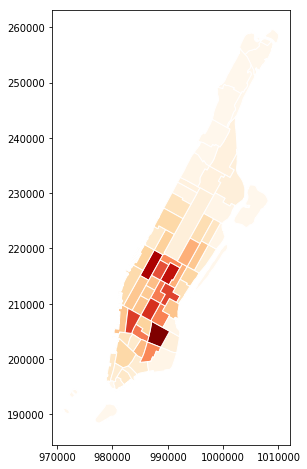

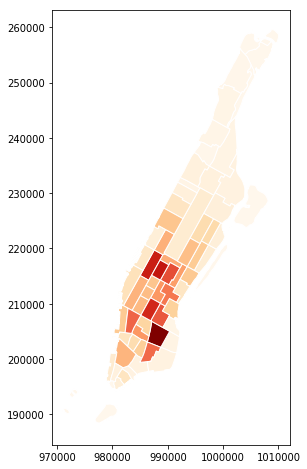

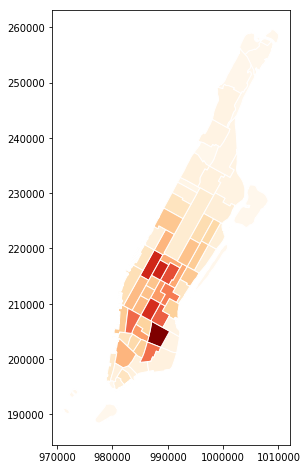

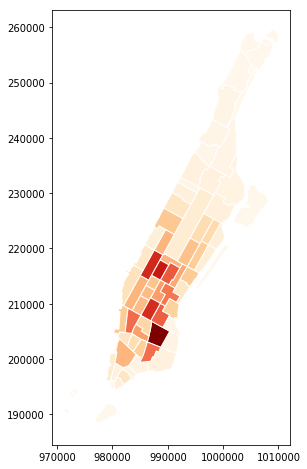

In [66]:
for group_name, group_data in valid_pred_5min.groupby(['tpep_pickup_5min_id']):
    print('group_name:', group_name)
    valid_pred_5min_group = group_data.groupby(['LocationID']).sum()[['value', 'pred_xgb', 'pred_lr', 'pred_lgb']]  # , 'pred_tf'
    taxi_zones_shape_requests_pred_5min = taxi_zones_shape.join(valid_pred_5min_group, on=['LocationID'], how='left')
    taxi_zones_shape_requests_pred_5min.fillna(0, inplace=True)
    taxi_zones_shape_requests_pred_5min.plot(column='value', cmap='OrRd', edgecolor='white')
    taxi_zones_shape_requests_pred_5min.plot(column='pred_xgb', cmap='OrRd', edgecolor='white')
    taxi_zones_shape_requests_pred_5min.plot(column='pred_lr', cmap='OrRd', edgecolor='white')
    #taxi_zones_shape_requests_pred_5min.plot(column='pred_tf', cmap='OrRd', edgecolor='white')
    taxi_zones_shape_requests_pred_5min.plot(column='pred_lgb', cmap='OrRd', edgecolor='white')

    break

In [67]:
valid_pred_5min_group

,value,pred_xgb,pred_lr,pred_lgb
LocationID,,,,
4,4.000,1.981,2.108,2.102
12,0.000,0.018,-0.024,0.185
13,8.000,6.751,7.915,6.826
24,3.000,1.633,1.503,1.625
41,3.000,3.603,3.644,3.927
42,3.000,2.044,1.742,2.078
43,4.000,6.387,6.830,6.370
45,6.000,2.977,3.553,3.040
48,57.000,53.491,55.879,54.123


In [68]:
# show evaluate result
print('valid_5min_xgb_mae:', valid_5min_xgb_mae)
print('valid_5min_lr_mae:', valid_5min_lr_mae)
#print('valid_5min_tf_mae:', valid_5min_tf_mae)
print('valid_5min_lgb_mae:', valid_5min_lgb_mae)

print('valid_15min_xgb_mae:', valid_15min_xgb_mae)
print('valid_15min_lr_mae:', valid_15min_lr_mae)
#print('valid_15min_tf_mae:', valid_15min_tf_mae)
print('valid_15min_lgb_mae:', valid_15min_lgb_mae)

print('valid_30min_xgb_mae:', valid_30min_xgb_mae)
print('valid_30min_lr_mae:', valid_30min_lr_mae)
#print('valid_30min_tf_mae:', valid_30min_tf_mae)
print('valid_30min_lgb_mae:', valid_30min_lgb_mae)

valid_5min_xgb_mae: 2.570875777084664
valid_5min_lr_mae: 2.685434983341258
valid_5min_lgb_mae: 2.6043024998629036
valid_15min_xgb_mae: 5.460938147147867
valid_15min_lr_mae: 6.341742248844984
valid_15min_lgb_mae: 5.603619223969387
valid_30min_xgb_mae: 9.76317715665435
valid_30min_lr_mae: 12.3371560812682
valid_30min_lgb_mae: 10.120641728407225


## Conclusion

The validate results show that XGBoost performs better than other algorithms. We can improve the results by adding more features and carefully tuning the parameters of the algorithm.